# GHG emissions of Czechia in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in Czechia.

In [1]:
from datetime import date
import os
import sys

import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../../"))

from data_analysis.emissions_pie_chart import *
from data_analysis.illustrator_strings import *
from data_analysis.sectors import *
from data_analysis.texts_emissions import *
from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.eurostat_geo import Geo
from data_analysis.eurostat_population_utils import get_eurostat_population_data_for_geo

### 1. The structure of the pie charts is defined (using CRF codes and EUA permit codes).

In [2]:
GEO = Geo.CZ
YEAR = 2023

definition = [
    get_sector_definition(Sector.ELECTRICITY_HEAT) |
    {'breakdown': [
        {'id': 'CHP',
         'label': 'Teplárny',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'remainder': True},
        {'id': 'pocerady',
         'label': 'Elektrárna Počerady',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': ['CZ-0204-05', 'CZ-0478-12'],
         'allowances': True},
        {'id': 'tusimice',
         'label': 'Elektrárna Tušimice',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': ['CZ-0209-05'],
         'allowances': True},
        {'id': 'prunerov',
         'label': 'Elektrárna Prunéřov',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': ['CZ-0206-05', 'CZ-0207-05'],
         'allowances': True},
        {'id': 'chvaletice',
         'label': 'Elektrárna Chvaletice',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': ['CZ-0200-05'],
         'allowances': True},
        {'id': 'ledvice',
         'label': 'Elektrárna Ledvice',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': ['CZ-0201-05'],
         'allowances': True},
        {'id': 'other-powerplants',
         'label': 'Ostatní elektrárny',
         'color': get_next_internal_subsector_color(Sector.ELECTRICITY_HEAT),
         'codes': [
             'CZ-0092-05', 'CZ-0202-05', 'CZ-0203-05',  # Elektrárna Mělník
             'CZ-0197-05',  # Teplárna a elektrárna Vřesová
             'CZ-0148-05', 'CZ-0417-06',  # Elektrárna Kladno
             'CZ-0080-05',  # Elektrárna Opatovice
             'CZ-0198-05',  # Elektrárna Dětmarovice
             'CZ-0208-05',  # Elektrárna Tisová
             'CZ-0317-05',  # Elektrárna Třebovice
             'CZ-0205-05',  # Elektrárna Poříčí
         ],
         'allowances': True}
    ]},
    get_sector_definition(Sector.INDUSTRY) |
    {'breakdown': [
        get_subsector_definition(Sector.INDUSTRY, Subsector.METAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.MINERAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.CHEMICAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.FUELS),
        {'id': 'other',
         'label': 'Ostatní průmysl',
         'color': get_next_internal_subsector_color(Sector.INDUSTRY),
         'remainder': True},
    ]},
    get_sector_definition(Sector.TRANSPORT) |
    {'breakdown': [
        get_subsector_definition(Sector.TRANSPORT, Subsector.CARS),
        get_subsector_definition(Sector.TRANSPORT, Subsector.TRUCKS_BUSES),
        get_subsector_definition(Sector.TRANSPORT, Subsector.AIRPLANES),
        {'id': 'other',
         'label': 'Ostatní doprava',
         'color': get_next_internal_subsector_color(Sector.TRANSPORT),
         'remainder': True}
    ]},
    get_sector_definition(Sector.BUILDINGS),
    get_sector_definition(Sector.AGRICULTURE),
    get_sector_definition(Sector.WASTE),
    get_sector_definition(Sector.OTHER),
]


### 2. Emissions values (in megatons) are loaded for all CRF codes and EUA permit codes that appear in the definition.

In [3]:
df = get_eurostat_crf_data_for_geo(GEO, YEAR)
df


,value
src_crf,
CRF1,76.81032
CRF1A,75.74428
CRF1A1,35.66166
CRF1A1A,33.71511
CRF1A1B,0.52816
...,...
CRF5F3,0.85641
CRF6,0.00000
CRF_INDCO2,0.43084


In [4]:
allowance_permit_codes = []
for wedge_def in definition:
    for sub_wedge in wedge_def.get('breakdown', []):
        allowance_permit_codes += sub_wedge['codes'] if 'allowances' in sub_wedge else []

df_eua = df_eua_filtered = pd.DataFrame()
if allowance_permit_codes:
    df_eua = get_allowances_data(
        YEAR, registry_code=GEO.value, main_activity_code=20, eua_path= f"../../../data/EUA/verified_emissions_{YEAR}_en.xlsx")
    df_eua_filtered = df_eua.loc[df_eua.index.isin(allowance_permit_codes),]
    df = pd.concat([df, df_eua_filtered])

print("Facilities on our list:")
df_eua_filtered

Facilities on our list:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
CZ-0204-05,4.094255,"Elektrárna Počerady, a.s.",20
CZ-0209-05,3.570884,ČEZ - Elektrárna Tušimice 2,20
CZ-0207-05,3.025634,ČEZ - Elektrárna Prunéřov 2,20
CZ-0200-05,2.893905,Elektrárna Chvaletice a.s.,20
CZ-0201-05,2.823304,ČEZ - Elektrárna Ledvice,20
CZ-0148-05,1.772349,Teplárna Kladno s.r.o.,20
CZ-0092-05,1.382611,ENERGOTRANS - Elektrárna Mělník 1,20
CZ-0197-05,1.243214,Teplárna a PPC Vřesová,20
CZ-0080-05,0.953248,Elektrárny Opatovice - Elektrárna Opatovice,20


In [5]:
print("Top facilities with main activity code 20 not in our list, check them carefully:")
df_eua.loc[~ df_eua.index.isin(allowance_permit_codes),].head(15)

Top facilities with main activity code 20 not in our list, check them carefully:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
CZ-0400-05,2.292832,UNIPETROL - Petrochemie,20
CZ-0101-05,1.418581,ENERGETIKA TŘINEC,20
CZ-0134-05,1.281302,Liberty Ostrava a.s.,20
CZ-0444-10,1.110904,TAMEH Czech,20
CZ-0160-05,0.746295,ORLEN UNIPETROL - Energoblok EJ,20
CZ-0190-05,0.511891,United Energy - Teplárna Komořany,20
CZ-0237-05,0.461891,ČEZ - Teplárna Trmice,20
CZ-0256-05,0.360807,ŠKO-ENERGO Teplárna Mladá Boleslav,20
CZ-0259-05,0.325753,TAMERO INVEST - Teplárna Kralupy,20


### 3. List of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator)

In [6]:
total_value = get_total_emissions_value(df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

df_wedges = print_emissions_wedges_to_csv(inner_wedges + outer_wedges, f"output-{GEO.value}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
electricity-heat,33.715110,None,Výroba elektřiny a tepla
industry,25.858520,None,Průmysl
transport,20.942160,None,Doprava (včetně letecké)
buildings,8.619250,None,Budovy
agriculture,8.131730,None,Zemědělství
waste,5.575790,None,Odpadové hospodářství
other,0.691270,None,Jiné
electricity-heat_CHP,8.101134,electricity-heat,Teplárny
electricity-heat_pocerady,4.690547,electricity-heat,Elektrárna Počerady


### 4. Strings (with occasional data) are generated for Illustrator.

In [7]:
population = get_eurostat_population_data_for_geo(GEO, YEAR)
emissions_per_person = total_value * 1_000_000 / population
lulucf_emissions = get_emissions_value("CRF4", df)
lulucf_emissions_abs = abs(lulucf_emissions)
lulucf_emissions_pct = (lulucf_emissions_abs / total_value) * 100

strings: dict[str, str] = {
  "country-name-l": "v ČR",
  "country-name-g": "České republiky",
  "year": YEAR,
  "total-weight": czech_float(total_value, 2),
  "total-per-person": czech_float(emissions_per_person, 2),
  "lulucf-emissions-abs": czech_float(lulucf_emissions_abs, 2),
  "lulucf-emissions-pct": czech_float(lulucf_emissions_pct, 0),
  "data-source": "Evropská agentura pro životní prostředí",
  "version": date.today().strftime("%Y-%m-%d"),
  "slug": "emise-cr",
}
df_strings = print_illustrator_strings_to_csv(strings, f"output-{GEO.value}-strings.csv")
df_strings

,value
id,
country-name-l,v ČR
country-name-g,České republiky
year,2023
total-weight,"103,53"
total-per-person,"9,56"
lulucf-emissions-abs,"3,57"
lulucf-emissions-pct,3
data-source,Evropská agentura pro životní prostředí
version,2025-09-18


### 5. A nested pie chart is generated (as a rough version of the final plot)

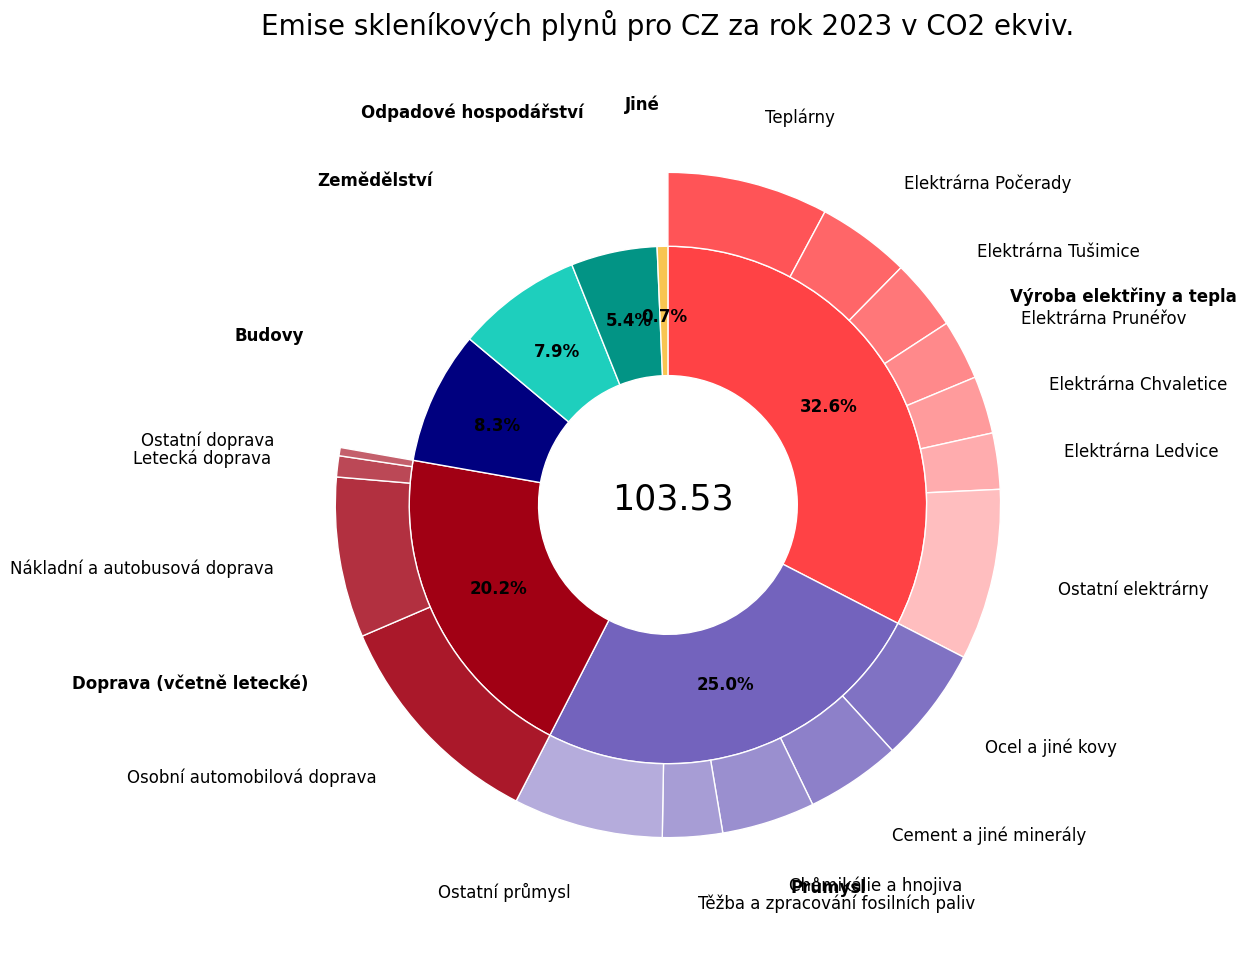

In [8]:
draw_emissions_pie_chart(GEO.value, YEAR, inner_wedges, outer_wedges, total_value)

### 6. Generate accompanying text for the web

First check the fact about top 5 coal plants vs. transport.

In [9]:
def _get(id: str) -> float:
    return df_wedges.loc[id, "value"]


if (_get("electricity-heat_pocerady") < max(_get("electricity-heat_ledvice"),
                                            _get("electricity-heat_prunerov"),
                                            _get("electricity-heat_tusimice"),
                                            _get("electricity-heat_chvaletice"))):
    print("Warning: Počerady is not the largest coal plant. Please rephrase the text in get_sectoral_info(Sector.ELECTRICITY_HEAT, ...)..")

total_5_largest = (_get("electricity-heat_pocerady") + _get("electricity-heat_ledvice") +
                   _get("electricity-heat_prunerov") + _get("electricity-heat_tusimice") +
                   _get("electricity-heat_chvaletice"))
road = _get("transport_cars") + _get("transport_trucks-buses")
print(f"Top 5 coal plants: {total_5_largest:.2f} Mt")
print(f"Road transport: {road:.2f} Mt")
print("Is it still similar? Consider rephrasing in get_sectoral_info(Sector.ELECTRICITY_HEAT, ...).")

Top 5 coal plants: 17.00 Mt
Road transport: 19.47 Mt
Is it still similar? Consider rephrasing in get_sectoral_info(Sector.ELECTRICITY_HEAT, ...).


In [10]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů v ČR podle sektorů"
slug:       "{strings["slug"]}"
redirect_from: ["/{strings["slug"]}", "/emise-cr-detail", "/infografiky/emise-cr-detail"]
published:  2019-07-20
weight:     50
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR za rok {YEAR} v jednotlivých sektorech lidské činnosti. Roční objem emisí České republiky je {strings["total-weight"]} mil. tun (údaj z roku {YEAR}). V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq/obyvatele."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {strings["version"]}. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf?

{get_gases_info()}

Roční objem emisí České republiky je {czech_float(total_value, 2)} mil. tun CO<sub>2</sub>eq (údaj z roku {YEAR}). __V přepočtu na obyvatele to je {czech_float(emissions_per_person, 2)} t CO<sub>2</sub>eq/obyvatele.__

## Co znamenají jednotlivé sektory?

* {get_sectoral_info(Sector.ELECTRICITY_HEAT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.INDUSTRY, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.TRANSPORT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.BUILDINGS, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.AGRICULTURE, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.WASTE, GEO, df_wedges, df, total_value, population)}

{get_lulucf_info(YEAR, GEO, lulucf_emissions)}

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:     infographic
title:      "Emise skleníkových plynů v ČR podle sektorů"
slug:       "emise-cr"
redirect_from: ["/emise-cr", "/emise-cr-detail", "/infografiky/emise-cr-detail"]
published:  2019-07-20
weight:     50
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR za rok 2023 v jednotlivých sektorech lidské činnosti. Roční objem emisí České republiky je 103,53 mil. tun (údaj z roku 2023). V přepočtu na obyvatele to je 9,56 t CO<sub>2</sub>eq/obyvatele."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on 2025-09-18. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf?

Všechny hodnoty v grafu jsou <glossary id="antropogennisklenikoveplyny">antropogenní emise</glossary> skleníkových plynů CO<sub>2</sub>, N<sub>2</sub>O, CH<sub>4</sub>, HFC, PFC, SF<sub>6</sub>, NF<sub>3</sub> vyjádřené jako <gloss

### 7. Generate accompanying text for the web - for the evolution since 1990

In [11]:
YEAR_FROM = 1990

df_from = get_eurostat_crf_data_for_geo(GEO, YEAR_FROM)
total_value_from = get_total_emissions_value(df_from)
inner_wedges_from = get_emissions_wedges(definition, total_value_from, df_from)
inner_from_dict = {wedge.id: wedge.value for wedge in inner_wedges_from}

decrease_by_percent = (1 - total_value / total_value_from) * 100

In [12]:
accompanying_text = f'''---
layout:        infographic
title:         "Emise skleníkových plynů v ČR v letech {YEAR_FROM}–{YEAR}"
slug:          "emise-cr-vyvoj"
redirect_from: "/emise-cr-vyvoj"
published:     2020-10-09
weight:        75
tags-scopes:   [ cr ]
tags-topics:   [ emise, energetika ]
caption:       "Vývoj emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR v jednotlivých sektorech lidské činnosti během let a jejich relativní změny. Od roku {YEAR_FROM}, kdy dosahovaly {czech_float(total_value_from, decimals=1)} mil. tun CO<sub>2</sub>eq, klesly celkové emise ČR na {czech_float(total_value, decimals=1)} mil. tun CO<sub>2</sub>eq v roce {YEAR}."
data-orig:
  - [ "Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions-over-time-eu.ipynb" ]
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
---

## Jak číst tento graf

{get_gases_info()}

V levé části grafu jsou vyobrazeny absolutní emise na území ČR v jednotkách CO<sub>2</sub>eq od roku {YEAR_FROM} až do roku {YEAR}. Jednotlivé oblasti lidské činnosti jsou barevně odlišeny. V pravé části je pak pro každou z těchto oblastí naznačena relativní změna v objemu emisí oproti roku {YEAR_FROM}.

V roce {YEAR_FROM} činil objem emisí na území dnešní České republiky {czech_float(total_value_from)} mil. tun CO<sub>2</sub>eq. V roce {YEAR} to bylo {czech_float(total_value)} mil. tun. To znamená, že během tohoto období klesly emise ČR o {decrease_by_percent:.0f} %. Většina tohoto poklesu, zhruba o čtvrtinu, však proběhla během devadesátých let. Od roku 2000 klesaly emise spíše pomaleji, vyšší propad způsobil útlum ekonomické aktivity během pandemie covidu-19 v roce 2020.

{{% include preview-box.html
    title="Jak se emise vyvíjí v rámci celé EU?"
    text="Obdobnou [infografiku](/infografiky/emise-eu-vyvoj) jsme vytvořili i pro Evropskou unii."
    slug="emise-eu-vyvoj"
%}}

## Co vidíme v jednotlivých sektorech

* {get_sectoral_evolution_info(Sector.ELECTRICITY_HEAT, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.INDUSTRY, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.TRANSPORT, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.BUILDINGS, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.AGRICULTURE, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.WASTE, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)

---
layout:        infographic
title:         "Emise skleníkových plynů v ČR v letech 1990–2023"
slug:          "emise-cr-vyvoj"
redirect_from: "/emise-cr-vyvoj"
published:     2020-10-09
weight:        75
tags-scopes:   [ cr ]
tags-topics:   [ emise, energetika ]
caption:       "Vývoj emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR v jednotlivých sektorech lidské činnosti během let a jejich relativní změny. Od roku 1990, kdy dosahovaly 196,9 mil. tun CO<sub>2</sub>eq, klesly celkové emise ČR na 103,5 mil. tun CO<sub>2</sub>eq v roce 2023."
data-orig:
  - [ "Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions-over-time-eu.ipynb" ]
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
---

## Jak číst tento graf

Všechny hodnoty v grafu jsou <glossary id="antropogennisklenikoveplyny">antropogenní emise</glossary> skleníkových plynů CO<sub>2</sub>, N<sub>2</sub>O, CH<sub>4</sub>, HFC,